---

title: "无限高斯混合模型"
date: 2025-02-03T14:00:00-06:00
author: 郝鸿涛
slug: igmm
draft: false
toc: true
tags: 统计
---

## 概念讲解

无限高斯混合模型 (Infinite Gaussian Mixture Model, IGMM) 是 [高斯混合模型](/cn/2024/11/21/gmm/) 的延伸。它处理这样的情况：我们不知道有几个簇 (cluster) 。

这时候大体上有两种解决办法。第一种是测试不同的簇数，然后比较哪个结果好，常用的方法有 [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) (使用 Sum of Squared Errors)、[Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)、[Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) 等。

第二种方法，也是我们这篇要讲的，假设有无数个簇。设数据点 $x_i$ 所属的簇为 $z_i = k$。其中 $k$ 表示一个具体的簇。我们假设每个簇的数据符合正态分布，$\mathcal{N}(\mu_k, \sigma_k^2)$。那我们最后想得到的是两个概率分布：

1. 对于一个数据点 $x_i$，我们想知道该数据点属于某一个簇的概率，$P(z_i = k|x_i)$，这是一个离散分布。
2. 已知某一簇所包含的数据点集合 $X_k = \{x_i|z_i = k\}$，我们想知道该簇参数的后验分布，即不同 $\mu_k$ 与 $\sigma_k^2$ 的概率分布，$P(\mu_k, \sigma_k^2|X_k)$，这是一个连续分布。

看到这里，你可能会问：(1) 我说了一个数据点属于某一簇只是一个概率事件，只要不是 100%，那我们就不知道它到底属于哪个簇。既然如此，我们如何知道 $X_k = \{x_i|z_i = k\}$? (2) 簇参数是一个分布，并不是具体的值，那如何算 $P(z_i = k|x_i)$? 如果你能问出这两个问题，我只能说你太牛逼了。先别急，接着往下看。

为了计算这两个概率，我们需要拿出「贝叶斯公式」这个杀手锏：

\begin{equation}
P(z_i = k|x_i) \propto P(z_i = k) \cdot P(x_i|z_i = k) =  P(z_i = k) \cdot P(x_i|\mu_k, \sigma_k^2) \tag{1}
\end{equation}

\begin{equation}
P(\mu_k, \sigma_k^2|X_k) \propto P(\mu_k, \sigma_k^2) \cdot \prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)\tag{2}
\end{equation}

对于公式 (1):

$ P(z_i = k)$ 是簇的先验概率。也就是说，我们在没有任何信息的情况下，如何推断一个数据点 $x_i$ 属于哪个簇。

$P(x_i|z_i = k)$ 表示在 $x_i$ 属于簇 $k$ 的条件下，数据点的似然 (Likelihood，你可以理解为「可能性」)。对于高斯分布，这个似然概率就是横坐标某一个 $x$ 所对应的密度值 (PDF)。也就是说，$P(x_i|z_i = k) = P(x_i|\mu_k, \sigma_k^2)$

对于公式 (2):

最后我们想得到的 $P(\mu_k, \sigma_k^2|X_k)$ 是关于给定 $X_k$ 这条信息后，我们对于该簇参数的认识。那我们选择什么分布来描述我们对参数的认识呢？

我们先看簇均值 $\mu_k$，可选的分布很多，比如正态分布、 T 分布、拉普拉斯分布等。$\sigma_k^2$ 的话，我们要确保 $\sigma_k^2 \ge 0$，可选的分布也有很多，比如伽马分布、逆伽马分布、卡方分布、对数正态分布、指数分布等。都可以保证结果（分布的随机变量）非负。

另外，我们需要注意的是，$P(\mu_k, \sigma_k^2|X_k)$ 是一个联合概率，因为 $\mu_k$ 与 $\sigma_k^2$ 是关联的。当 $\sigma_k^2$ 比较小时，我们对均值的不确定性就比较小。因此，后验分布也需要描述它们的关系。

$\prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)$ 是将多个正态分布密度函数相乘。但是在具体计算时，我们是逐点计算：

\begin{equation}
P(\mu_k, \sigma_k^2|x_i, z_i = k) \propto P(\mu_k, \sigma_k^2) \cdot P(x_i|\mu_k, \sigma_k^2)\tag{3}
\end{equation}

对 $X_k$ 中的所有点算一遍，最后的结果就是 $P(\mu_k, \sigma_k^2|X_k)$

这里为什么逐点计算的结果和连乘的结果一样？设想，对于集合 $X_k$ 中第一个数据点，$P(\mu_k, \sigma_k^2) \cdot P(x_1|\mu_k, \sigma_k^2)$ 得到的后验是计算 $x_2$ 时的先验。所以逐点计算和该簇所有点一起计算，结果是一样的。

现在的问题是，我们如何选择均值和方差的分布，以满足上面的两个个要求：(1) 符合实际。也就是从上面列出的可选分布中选。(2) 是一个联合概率。另外，最好符合第三个要求 （3）计算方便。

科学家发现一个很巧的事情：如果先验概率我们选择用正态分布描述均值，用逆伽马分布描述方差，那么和 $\prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)$ 相乘之后，最后得到的分布和先验分布形式相同，也是「正态-逆伽马分布」 ([Normal-Inverse-Gamma Distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution))。这就大大简化了计算量，所以我们选择用正态分布描述均值，用逆伽马分布描述方差。其中，数据决定逆伽马函数，而逆伽马函数决定了正态分布。这样一来，上面的三个要求全都满足了。

更多这种很巧的案例可以参考「[共轭先验](https://en.wikipedia.org/wiki/Conjugate_prior)」。

## 具体的计算过程

我们来讲一下具体怎么计算。我们是逐点计算的，也就是对每一个数据点进行遍历。

### 公式 (3)

我们先来看公式 (3)。

假设当前的先验 $P(\mu_k, \sigma_k^2)$ 是正态-逆伽马分布：

$$\sigma^2 \sim \text{InvGamma}(\alpha_0, \beta_0)$$

$$\mu|\sigma^2 \sim \mathcal{N}(\mu_0, \frac{\sigma^2}{\kappa_0})$$

其中：

- $\alpha_0, \beta_0$：控制方差分布的形状
- $\mu_0$：均值的先验均值
- $\kappa_0$：对均值先验的确信程度

属于某簇 $k$ 的一个新数据点 $x_i$ 的似然函数：

$$P(x_i|\mu_k, \sigma_k^2) = \frac{1}{\sqrt{2\pi\sigma_k^2}}\exp\left( -\frac{(x_i - \mu_k)^2}{2\sigma_k^2} \right)$$

需要注意的是，$\mu_k$ 和 $\sigma_k^2$ 是该簇参数当前的后验分布，即 $P(\mu_k, \sigma_k^2|X_k)$。也就是说，它们本身也是一个分布，而不是一个确定的值。对于该簇的「第一个」数据点，$\mu_k$ 和 $\sigma_k^2$ 就是先验分布。

$\mu_k$ 和 $\sigma_k^2$ 是分布，而非具体的值，但是 $P(x_i|\mu_k, \sigma_k^2)$ 确确实实是一个具体的值，怎么办？我们需要考虑所有的 $\mu$ 和 $\sigma^2$，然后取加权平均。权重就是每个  $\mu$ 和 $\sigma^2$ 在$P(\mu_k, \sigma_k^2|X_k)$ 中的密度值：

$$P(x_i|\mu_k, \sigma_k^2) = \int_{\mu} \int_{\sigma^2} P(x_i|\mu, \sigma^2) \cdot P(\mu, \sigma^2|X_k) \cdot d\mu \cdot d\sigma^2 \tag{4}$$

根据公式 (3)，这个双重积分还要在乘上 $P(\mu_k, \sigma_k^2)$ 这个先验分布，那真是「难算他妈给难算开门，难算到家了」。

不过好在数学家已经提前算好了：如果 $P(\mu_k, \sigma_k^2)$ 用正态-逆伽马分布的话，带入上面的公式，得到的结果依然是一个正态-逆伽马分布，这就是「共轭先验」。

这样一来，我们直接根据这些先辈得出的「共轭先验」的性质就可以更新正态-逆伽马分布的参数：

- $\kappa_n = \kappa_0 + n$
- $\mu_n = \frac{\kappa_0\mu_0 + n \bar{x}}{\kappa_n}$
- $\alpha_n = \alpha_0 + \frac{n}{2}$
- $\beta_n = \beta_0 + \frac{1}{2}\sum(x_i - \bar{x})^2 + \frac{\kappa_0n(\bar{x}-\mu_0)^2}{2\kappa_n}$

也就是说，我们的后验分布为：

$$\sigma_\text{post}^2 \sim \text{InvGamma}(\alpha_n, \beta_n)$$

$$\mu_\text{post}|\sigma_\text{post}^2 \sim \mathcal{N}(\mu_n, \frac{\sigma_\text{post}^2}{\kappa_n})$$

这里有两点需要格外注意，第一点，上面给出的公式，如果是逐点更新 (incremental updating) 后验分布参数的话，那么 $n = 1, \bar{x} = x_i$。 如果批量更新 (batch updating)，也就是先把所有的数据点都算完，我们知道了每个簇包含的所有点之后再一起更新参数，那 $n$ 是该簇总共有多少个数据点，$\bar{x}$ 是这些数据的均值。通常来说，为了计算方便，我们更倾向使用批量更新。

如果使用批量更新，我们需要最后得到每一个簇的 $n$ 与 $\bar{x}$。那我们在逐点计算的时候，需要更新 $X_k = \{x_i|z_i = k\}$，也就是把每一个数据点 $x_i$ 分配到一个具体的簇。但是根据公式 (1)，任一数据点的簇所属是一个分布，即 $P(z_i = k|x_i)$，而非一定值。

我们主要有两种处理方法：

1. 最大后验估计 (Maximum A Posteriori, MAP)。也就是找到 $P(z_i = k|x_i)$ 最大时对应的 $k^*$。

2. 随机采样。从 $P(z_i = k|x_i)$ 按照权重随机采样，得到一个具体的 $k$。

我们通常选择第二种方法，这样可以保留不确定性。

### 公式 (1)

但是在计算公式 (1) 的时候，我们就没有那么幸运了。如果精确计算的话，我们必须用上面的双重积分公式来计算 $P(x_i|\mu_k, \sigma_k^2)$。这种计算很复杂，为了简化，我们最好让 $\mu_k$ 和 $\sigma_k^2$ 是一个具体的值，而不是分布，这样的话，直接带入正态分布的密度函数就好了。那如何找到这两个具体的值？

我们知道 $\mu_k, \sigma_k^2 \sim P(\mu_k, \sigma_k^2|X_k)$，那我们可以

1. 随机采样。从该后验分布中，随机采多个值，计算 $P(x_i|\mu_k, \sigma_k^2)$，然后取平均值：

$$P(x_i|\mu_k, \sigma_k^2) = \frac{1}{S} \sum_{s=1}^S P(x_i|\mu_k^{(s)}, \sigma_k^{2(s)}) \tag{5}$$

其中 $S$ 是采样次数。

这里我想多介绍一下。这种方法被称为蒙特卡洛积分 ([Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration))。我们上面提到过，公式四的本质就是一个取加权平均的过程。它非常复杂，解析解很难获得。我们的办法是从参数函数中采样，这本身就包含了「加权」，因为高概率区域采样频率高，贡献大，反之亦然。

2. 最大后验估计 (Maximum A Posteriori, MAP)，也就是取密度最高的值。

一般情况下，我们选择随机采样以保留不确定性。

对于 $P(z_i = k)$，一般的教材中都直接用 Dirichlet Process 或者 Chinese Restaurant Process，但我们为了简单，不假设有无数个簇。而是说：我们知道可能是两个簇，不确定，但肯定不会多于 10 个簇。那我们就用均匀分布 Uniform Distribution。当然也可以可以用多项分布，Multinomial Distribution 等。因为数据如果够多，先验分布没那么重要，我们还是用均匀分布来做简单计算。

### 总结

我们来总结一下计算的流程，也就是具体的算法。

我们是逐点计算：遍历每一个数据点。对于公式 (2)，根据共轭先验，我们使用该簇所包含的数据点数量 $n$ 以及这些数据点的均值 $\bar{x}$， 就可以直接更新簇参数后验分布 $P(\mu_k,\sigma_k^2|X_k)$。但是由于给定一个数据点的簇分布 $P(z_i=k|x_i)$ 非具体值，我们选择单次随机采样，得到一个具体的 $k$。这样对于所有的数据点遍历之后，我们就知道了每个簇的 $n$ 与 $\bar{x}$。

公式 (1) 中，$P(x_i|\mu_k, \sigma_k^2)$ 的精确计算需要双重积分这种高强度计算，我们选择避开它，对参数后验分布 $P(\mu_k,\sigma_k^2|X_k)$ 进行多次随机采样，得到多个 $\mu_k$ 和 $\sigma_k^2$，然后将数据点 $x_i$ 带入 $\mathcal{N}(\mu, \sigma^2)$ 的概率密度函数 (PDF) 中，得到多个 $P(x_i|\mu_k, \sigma_k^2)$ 值之后取平均值。这个过程要对每一个簇 ($k$) 进行，这样才能得到我们想要的离散分布 (该数据点属于不同簇的概率分布)。

## 开工

Talk is cheap, show me the code.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import invgamma
import time
from collections import defaultdict
from numba import jit

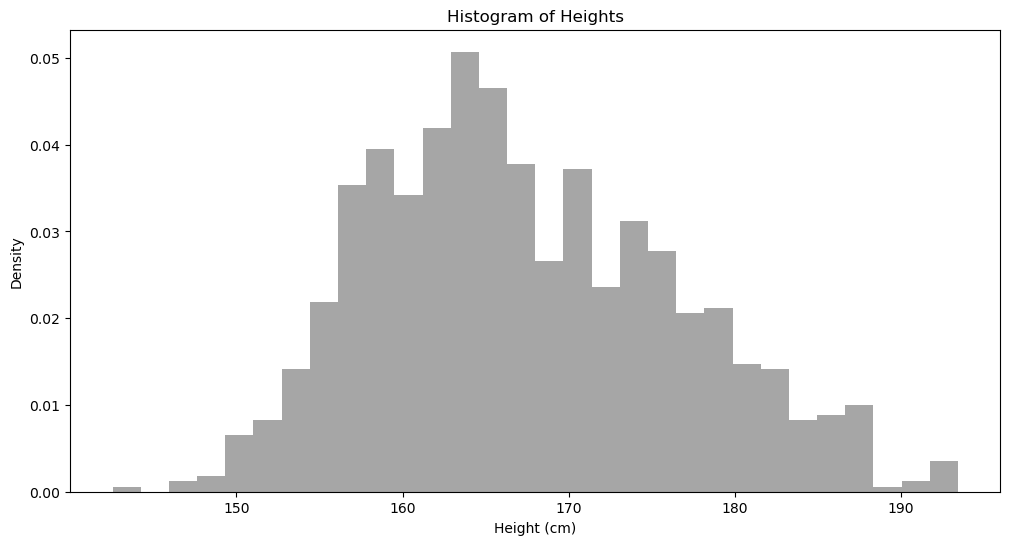

In [2]:
#|code-fold:true
np.random.seed(42)
n_female = 600
mu_female = 162
sd_female = 6
n_male = 1000 - n_female
mu_male = 175
sd_male = 7

female_heights = np.random.normal(mu_female, sd_female, n_female)
male_heights = np.random.normal(mu_male, sd_male, n_male)
heights = np.concatenate([female_heights, male_heights])
np.random.shuffle(heights)
data = heights.copy()

plt.figure(figsize=(12, 6))
plt.hist(data, bins = 30, density=True, alpha=0.7, color='gray')
plt.title('Histogram of Heights')
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.show()

In [11]:
# setting
iterations = 10
nclusters = 10
nsampling = 10

# history of P(z_i=k|x_i)
p1_history = []
# history of P(mu_k, sigma_k|X_k)
params_history = []

default_cluster_params = {}
for k in range(nclusters):
    default_cluster_params[k] = {
        'mu': np.random.uniform(min(data), max(data)),
        'kappa': 1,
        'alpha': 1,
        'beta': np.var(data)
    }
cluster_params = default_cluster_params.copy()

start_time = time.time()

# Initialize P(z_i = k) as uniform distribution 
P_z = np.ones(nclusters)/nclusters

for it in range(iterations):
    # if assignments = [2] means the first data point belongs to the 3rd cluster
    assignments = []

    # Initialize a list to store p1 for all data points in this iteration
    p1_iteration = []

    for d in data:
        # Step 1: Calculate P(z_i = k | x_i)
        # Length is nclusters. 
        p1 = []
        # for each cluster, sample and 
        # get weighted average of P(x_i|mu_k, sigma_k^2)
        for k in range(nclusters):
            mus = []
            sigmas = []
            for _ in range(nsampling):
                sigma2 = invgamma.rvs(
                    cluster_params[k]['alpha'], 
                    scale = cluster_params[k]['beta']
                )
                sigma = np.sqrt(sigma2)
                mu = norm.rvs(
                    cluster_params[k]["mu"], 
                    sigma/np.sqrt(cluster_params[k]['kappa'])
                )
                mus.append(mu)
                sigmas.append(sigma)
            
            # norm.pdf() result is too small, use LogSumExp to escape underflow
            log_likelihoods = [norm.logpdf(
                d, mu, sigma) for mu, sigma in zip(mus, sigmas)]
            max_log_likelihood = np.max(log_likelihoods)
            log_sum_exp = max_log_likelihood + np.log(
                np.sum(np.exp(log_likelihoods - max_log_likelihood)))
            average_likelihood = np.exp(log_sum_exp)/len(log_likelihoods)

            # Multiply by prior P(z_i = k), according to Eq (1) in main text
            p1.append(P_z[k] * average_likelihood)

        # Step 2: Assign data point to a cluster
        if np.sum(p1) == 0:
            probs = np.ones(nclusters)/nclusters
        else:
            probs = p1 / np.sum(p1)
        
        # 0-9
        choice = np.random.choice(nclusters, p=probs)
        assignments.append(choice)

        # Store p1 for the current data point
        p1_iteration.append(p1.copy())
    
    # Update P(z_i = k)
    P_z = np.zeros(nclusters)
    for k in range(nclusters):
        P_z[k] = np.sum(np.array(assignments) == k)/len(data)

    # Step 3: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k in range(nclusters):
        cluster_data_idx = [i for i, val in enumerate(assignments) if val == k]
        cluster_data = data[cluster_data_idx]
        n = len(cluster_data)
        if n == 0:
            # if cluster is empty, no need to calculate below
            # move on to the next k
            continue
        x_bar = np.mean(cluster_data)
        k_params = default_cluster_params[k]
        kappa_n = k_params['kappa'] + n
        mu_n = (k_params['kappa'] * k_params['mu'] + n * x_bar) / kappa_n
        alpha_n = k_params['alpha'] + 0.5 * n
        beta_n = k_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
            k_params['kappa'] * n * (x_bar - k_params['mu'])**2) / (2 * kappa_n)
            
        cluster_params[k] = {
            'mu': mu_n,
            "kappa": kappa_n,
            "alpha": alpha_n,
            "beta": beta_n
        }
    
    # keep data from this iteration 
    if (it + 1)%1 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
    # Make a copy 
    p1_history.append(list(p1_iteration))
    params_history.append([cluster_params[k] for k in range(nclusters)])

Iteration 1 completed! Time elapsed: 6.00s
Iteration 2 completed! Time elapsed: 12.11s
Iteration 3 completed! Time elapsed: 18.28s
Iteration 4 completed! Time elapsed: 24.43s
Iteration 5 completed! Time elapsed: 30.78s
Iteration 6 completed! Time elapsed: 36.79s
Iteration 7 completed! Time elapsed: 42.84s
Iteration 8 completed! Time elapsed: 49.07s
Iteration 9 completed! Time elapsed: 55.56s
Iteration 10 completed! Time elapsed: 61.73s


上面的代码中有许多点需要说明和注意。

每次迭代后，`assignments` 记录了每个点的簇归属。那我们可以用这个来更新 $P(z_i = k)$。也就是说，虽然我们一开始 $P(z_i = k)$ 用的是均匀分布，但第一次迭代后，以及每次迭代后，就可以根据最新的 `assignments` 来更新它。

`p1_iteration` 记录某一具体迭代中所有的 `p1`，而 `p1` 是一个具体数据点在所有簇上的未归一化后验概率 (Unnormalized Posterior Probability)，也就是公式一中的 $P(z_i = k) \cdot P(x_i|\mu_k, \sigma_k^2)$。而 `p1_history` 是所有 `p1_iteration` 的集合。

这里有一个问题，我们需要在把 `p1` 放进 `p1_iteration` 之前进行标准化吗？答案是不需要。

我们记录 `p1_history` 的目的是什么？最主要的目的是看模型是否收敛。那怎么判断模型是否收敛？通过计算并画出每次迭代后整体数据的可能性，即：

$$P(X) = \prod_{i=1}^{n} P(x_i)$$

其中 $X$ 代表所有的数据点，$n$ 表示数据量。

直接如此计算会导致[算术下溢 (Arithmetic underflow)](https://en.wikipedia.org/wiki/Arithmetic_underflow)。我们通常计算对数似然：

$$\log P(X) = \sum_{i=1}^n \log P(x_i)$$

那 $P(x_i)$ 是什么？它是边际似然 (Marginal Likelihood) 或者证据 (Evidence)。它也是公式一中的归一化参数。

细看一下公式一：

$$P(z_i = k|x_i) = \frac{P(x_i|z_i = k) P(z_i = k)}{P(x_i)} = \frac{P(x_i|z_i = k) P(z_i = k)}{\sum_{k'} P(x_i | z_i = k') P(z_i = k')}$$

所以 $P(x_i)$ 就是 `sum(p1)`。理解了这一点你也就理解了全部。

我们接下来看一下如何计算与每一次迭代相对应的 log likelihood。这样，计算所有迭代的结果后，我们就可以画出似然变化趋势图 (Likelihood Progression)。

In [12]:
def compute_log_likelihood(p1_iteration: np.ndarray) -> float:
    """计算单次迭代的 log-likelihood"""
    # p_x = np.sum(p1_iteration, axis=1)  # 计算所有数据点的 P(x_i)
    # This is to account for when we use dp as prior later
    p_x = np.array([np.sum(p1) for p1 in p1_iteration]) 
    return np.sum(np.log(p_x + 1e-10))  # 避免 log(0)

def obtain_log_likelihoods(p1_history: np.ndarray) -> list:
    """计算所有迭代的 log-likelihood"""
    return [compute_log_likelihood(p1_iteration) for p1_iteration in p1_history]

In [13]:
#|code-fold:true

def extract_cluster_means_and_variances(params, nclusters):
    """
    Extract cluster means and variances over iterations from parameter history.
    
    Args:
        params (list): A list of cluster parameters for each iteration.
        nclusters (int): Number of clusters.

    Returns:
        cluster_means (dict): Mean values for each cluster across iterations.
        cluster_variances (dict): Variance values for each cluster across iterations.
    """
    iterations = len(params)  # Number of iterations
    cluster_means = {k: [] for k in range(nclusters)}
    cluster_variances = {k: [] for k in range(nclusters)}

    # Extract means and variances for each cluster
    for it in range(iterations):
        for k in range(nclusters):
            cluster_means[k].append(params[it][k]['mu'])
            cluster_variances[k].append(1 / params[it][k]['alpha'])  # Approximation for variance

    return cluster_means, cluster_variances

def plot_cluster_means(cluster_means, iterations):
    """
    Plot the convergence of cluster means over iterations.

    Args:
        cluster_means (dict): Mean values for each cluster across iterations.
        iterations (int): Total number of iterations.
    """
    plt.figure(figsize=(12, 6))
    for k, means in cluster_means.items():
        plt.plot(range(iterations), means, label=f"Cluster {k} Mean")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster Mean (μ)")
    plt.title("Cluster Mean Convergence")
    plt.legend()
    plt.show()

def plot_cluster_variances(cluster_variances, iterations):
    """
    Plot the convergence of cluster variances over iterations.

    Args:
        cluster_variances (dict): Variance values for each cluster across iterations.
        iterations (int): Total number of iterations.
    """
    plt.figure(figsize=(12, 6))
    for k, variances in cluster_variances.items():
        plt.plot(range(iterations), variances, label=f"Cluster {k} Variance")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster Variance (σ²)")
    plt.title("Cluster Variance Convergence")
    plt.legend()
    plt.show()

# Step 2: Bar chart for cluster sizes
def plot_cluster_sizes(assignments):
    cluster_sizes = np.bincount(assignments)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
    plt.title("Cluster Sizes")
    plt.xlabel("Cluster Index")
    plt.ylabel("Number of Points")
    plt.show()

    
def plot_log_likelihood_progression(p1s):
    log_likelihoods = obtain_log_likelihoods(p1s)
    
    # 画图
    plt.figure(figsize=(10, 5))
    plt.plot(log_likelihoods, marker='o', linestyle='-')
    plt.title("Log-Likelihood Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.grid()
    plt.show()


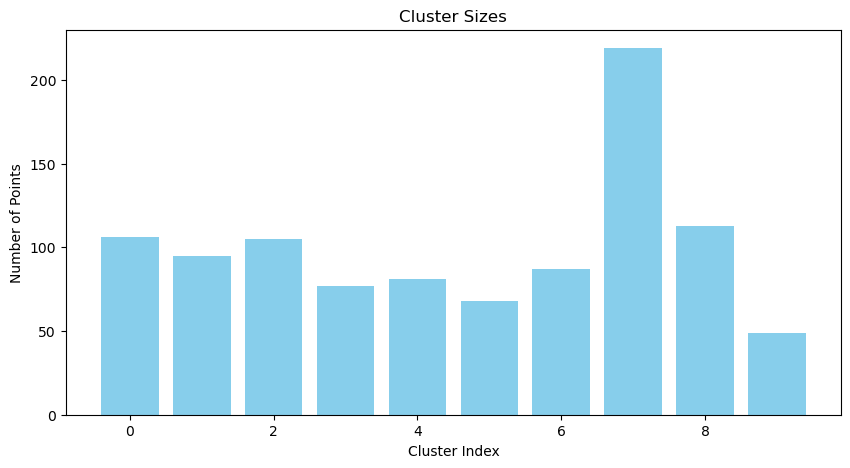

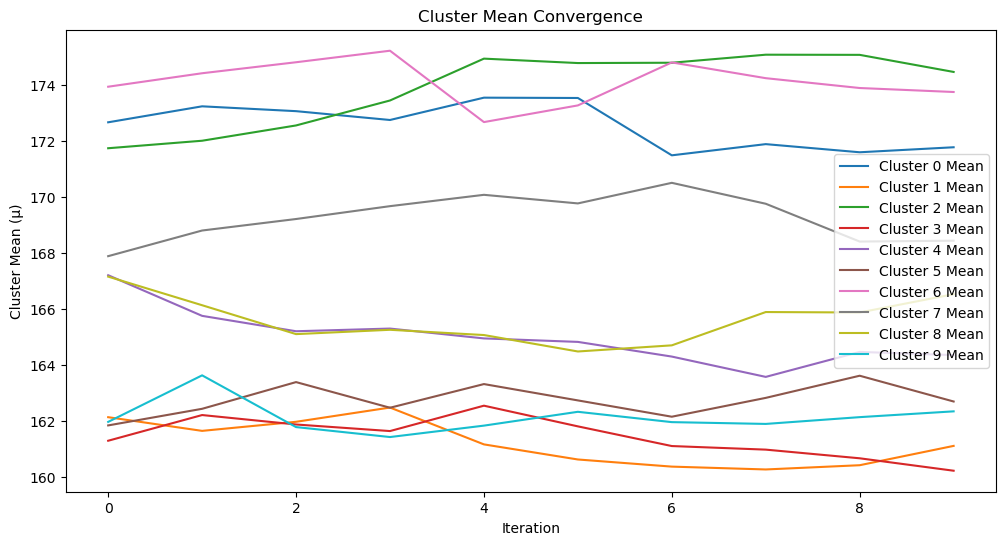

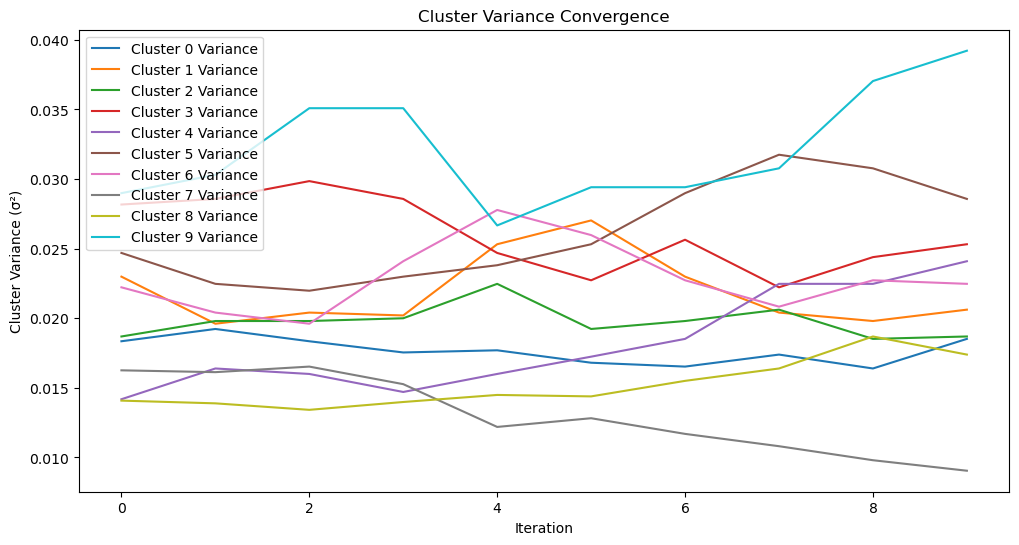

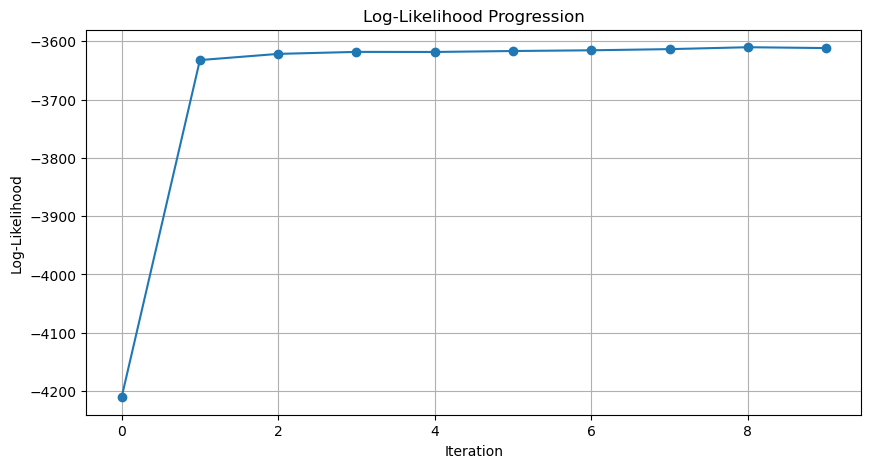

In [14]:
plot_cluster_sizes(assignments)

# Extract cluster means and variances
cluster_means, cluster_variances = extract_cluster_means_and_variances(params_history, nclusters)
# Plot cluster means
plot_cluster_means(cluster_means, len(params_history))
# Plot cluster variances
plot_cluster_variances(cluster_variances, len(params_history))

plot_log_likelihood_progression(p1_history)

### 优化

我们看到，我们的算法非常慢，10 次迭代竟然需要一分钟！下面我尝试通过「向量运算」的方式进行优化:

1. 把 `[norm.logpdf(d, mu, sigma) for mu, sigma in zip(mus, sigmas)]` 变成下面的 `calculate_average_likelihood(d, mus, sigmas)`。这样我们就避免了 for loop。

2. 我们是逐点计算 $P(\mu_k, \sigma^2_k|X_k)$，这本身没问题，但是我们没必要逐点对每个簇的参数，即 $\mu$ 与 $\sigma^2_k$，进行采样。这是因为，采样由每个簇的参数后验决定，而参数后验是在每次迭代结束的时候才更新，而不是逐点更新。所以我们在每次迭代开始时、遍历每个数据点之前对 $\mu$ 与 $\sigma^2_k$ 进行采样和估值即可。

In [15]:
# Dirichlet multinomial 

@jit(nopython=True)
def calculate_average_likelihood(d: float, mus: np.ndarray, sigmas: np.ndarray):
    """Vectorized log likelihood calculation with numerical stability.

    Args:
        d: A scalar or np.array of data points.
        mus: A np.ndarray of means.
        sigmas: A np.ndarray of standard deviations.

    Returns:
        The average likelihood.

    log(exp(-(x-μ)²/(2σ²)) / sqrt(2πσ²)) 
        = -(x-μ)²/(2σ²) - log(sqrt(2πσ²))
        = -(x-μ)²/(2σ²) - 0.5*log(2π) - log(σ)
    """
    # Calculate log likelihoods
    log_likelihoods = -0.5 * np.log(2 * np.pi) - np.log(sigmas) - \
                      0.5 * ((d - mus) / sigmas) ** 2

    # Use log-sum-exp trick for numerical stability
    max_log_likelihood = np.max(log_likelihoods)
    log_sum_exp = max_log_likelihood + np.log(
        np.sum(np.exp(log_likelihoods - max_log_likelihood)))
    
    # Return the average likelihood
    return np.exp(log_sum_exp) / len(mus)

# setting
iterations = 1000
nclusters = 10
nsampling = 10

# history of P(z_i=k|x_i)
p1_history = []
# history of P(mu_k, sigma_k|X_k)
params_history = []
n_data = len(data)

default_cluster_params = {}
for k in range(nclusters):
    default_cluster_params[k] = {
        'mu': np.random.uniform(min(data), max(data)),
        'kappa': 1,
        'alpha': 1,
        'beta': np.var(data)
    }
cluster_params = default_cluster_params.copy()

start_time = time.time()

# Initialize P(z_i = k) as uniform distribution
P_z = np.ones(nclusters) / nclusters
for it in range(iterations):
    # For each cluster, sample and get weighted average of P(x_i|mu_k, sigma_k^2)
    all_mus = {}
    all_sigmas = {}
    for k, k_params in cluster_params.items():
        sigma2_samples = invgamma.rvs(
            k_params['alpha'], 
            scale = k_params['beta'],
            size = nsampling
        )
        sigma_samples = np.sqrt(sigma2_samples)
        mu_samples = norm.rvs(
            k_params["mu"], 
            sigma_samples/np.sqrt(k_params['kappa'])
        )
        all_mus[k] = mu_samples
        all_sigmas[k] = sigma_samples
    
    # Assigning each data point to a cluster
    assignments = np.zeros(n_data, dtype = np.int64)

    # Store the prob of this data point belonging to different specific clusters
    p1 = np.ndarray(shape=(n_data, nclusters), dtype = float)
    for idx, d in enumerate(data):
        # Step 1: Calculate P(z_i = k | x_i) for all clusters
        for k_idx, k in enumerate(cluster_params.keys()):
            # Prior times likelihood
            p1[idx][k_idx] = P_z[k] * calculate_average_likelihood(d, all_mus[k], all_sigmas[k])
        
        # Step 2: Assign data point to a cluster
        if np.sum(p1[idx]) == 0:
            probs = np.ones(nclusters)/nclusters
        else:
            probs = p1[idx] / np.sum(p1[idx]) 
        # 0-9
        choice = np.random.choice(nclusters, p=probs)
        assignments[idx] = choice

    # Step 3: Update P(z_i = k)
    # minlenth = nclusters here makes sure all clusters have a prob
    # Just imagine assignments is all 1s: [1, 1, 1, 1, 1]
    P_z = np.bincount(assignments, minlength=nclusters) / n_data

    # Step 4: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k in range(nclusters):
        cluster_data_idx = [i for i, val in enumerate(assignments) if val == k]
        cluster_data = data[cluster_data_idx]
        n = len(cluster_data)
        if n == 0:
            # if cluster is empty, no need to calculate below
            # move on to the next k
            continue
        x_bar = np.mean(cluster_data)
        k_params = default_cluster_params[k]
        kappa_n = k_params['kappa'] + n
        mu_n = (k_params['kappa'] * k_params['mu'] + n * x_bar) / kappa_n
        alpha_n = k_params['alpha'] + 0.5 * n
        beta_n = k_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
            k_params['kappa'] * n * (x_bar - k_params['mu'])**2) / (2 * kappa_n)
            
        cluster_params[k] = {
            'mu': mu_n,
            "kappa": kappa_n,
            "alpha": alpha_n,
            "beta": beta_n
        }
    
    # keep data from this iteration 
    if (it + 1)%100 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
    p1_history.append(p1.copy())
    params_history.append([cluster_params[k] for k in cluster_params.keys()])

Iteration 100 completed! Time elapsed: 2.70s
Iteration 200 completed! Time elapsed: 4.70s
Iteration 300 completed! Time elapsed: 6.69s
Iteration 400 completed! Time elapsed: 8.74s
Iteration 500 completed! Time elapsed: 10.79s
Iteration 600 completed! Time elapsed: 12.79s
Iteration 700 completed! Time elapsed: 14.81s
Iteration 800 completed! Time elapsed: 16.77s
Iteration 900 completed! Time elapsed: 18.75s
Iteration 1000 completed! Time elapsed: 20.72s


明显快了很多。现在 1000 次迭代只需要 20 秒。

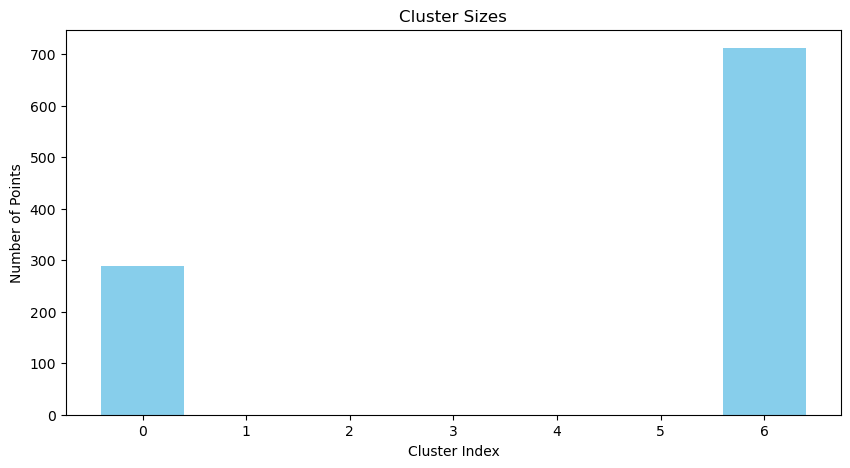

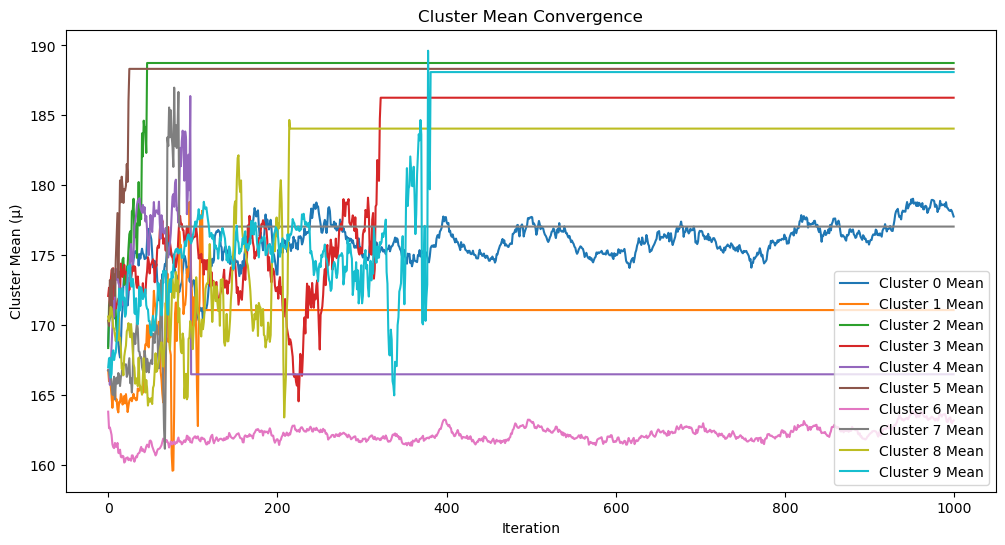

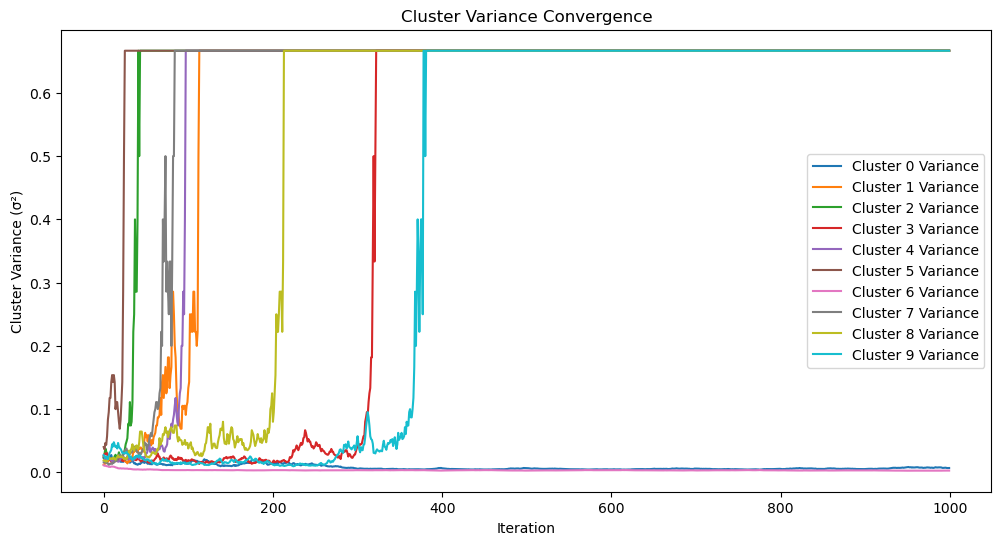

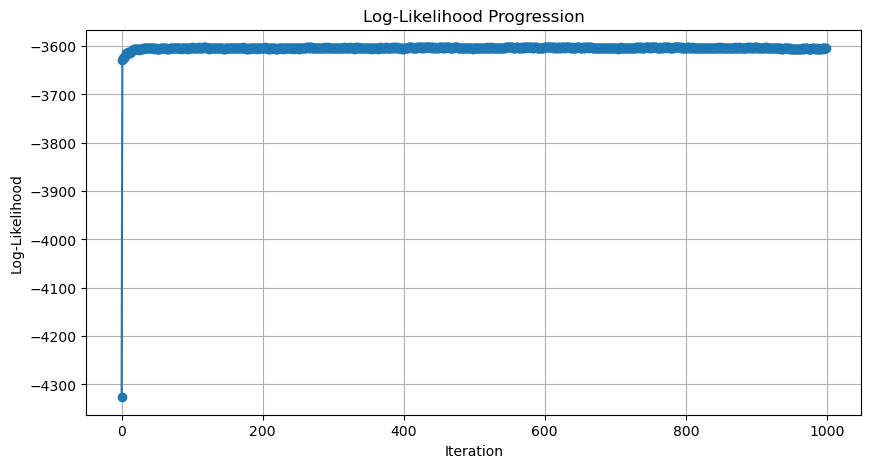

In [16]:
plot_cluster_sizes(assignments)

# Extract cluster means and variances
cluster_means, cluster_variances = extract_cluster_means_and_variances(
    params_history, nclusters)
# Plot cluster means
plot_cluster_means(cluster_means, len(params_history))
# Plot cluster variances
plot_cluster_variances(cluster_variances, len(params_history))

plot_log_likelihood_progression(p1_history)

## 后验预测分布 

我们可以用后验预测分布 (Posterior Predictive Distribution) 来检测我们的模型是否正确。

上面，我们的代码最后有两个结果：`assignments` 和 `cluster_params`。前者是每个数据点的簇所属，后者是每个簇的后验分布参数。

那如果我问你，两个新的数据点，$166$ 和 $176$，哪个出现的概率比较大？为了回答这个问题，比较「一劳永逸」的方法是从负无穷到正无穷这个区间，我们计算出每个数据点的概率密度 (Probability Density)。这就是后验预测分布。

从数学上来看，我们是在计算

$$P(X_\text{new}) = \sum_{k=1}^K P(z_\text{new}=k)\cdot P(X_\text{new}|\mu_k, \sigma_k)$$

其中 $X_\text{new}$ 表示的是从负无穷到正无穷这个区间上的连续值，而非一个具体数值。

我们来证明该分布的积分为 1:

$$
\begin{aligned} 
\int_{-\infty}^{\infty} P(X_\text{new}) dX_\text{new} &
= \int_{-\infty}^{\infty} \sum_{k=1}^K P(z_\text{new}=k)\cdot P(X_\text{new}|\mu_k, \sigma_k) dX_\text{new}\\ &
= \sum_{k=1}^K P(z_\text{new}=k) \int_{-\infty}^{\infty} P(X_\text{new}|\mu_k, \sigma_k) dX_\text{new} \\ &
= 1 \cdot 1 \\ &
= 1
\end{aligned}
$$

在真实计算时，有两个问题需要考量。第一，我们不需要算 $(-\infty, \infty)$ 这个区间所有的 $X_\text{new}$。为了检验模型的准确性，我们只需要计算原本数据的区间就可以，即 $X_{\text{new}} \in [\min(\text{data}), \max(\text{data})]$。

其次，$P(X_\text{new}|\mu_k, \sigma_k)$ 无法直接结算，因为 $\mu_k, \sigma_k$ 是分布，而非具体值。我们采用随机采样，然后取平均值。我们在公式 (4) 提到过。

In [17]:
from typing import Dict 

def posterior_predictive(
    x_new:np.ndarray, 
    assignments: np.ndarray, 
    cluster_params:Dict[int, Dict[str, float]],
    nsampling: int = 100
    ) -> np.ndarray:
    """
    Obtain posterior predictive likelihoods for every float in x_new
    """
    px_new = np.zeros_like(x_new, dtype=np.float64)

    # P_z: P(z_i = k) 
    P_z = np.bincount(assignments, minlength=len(cluster_params)) / len(assignments)

    # Iterate through all clusters
    # We should resample rather than using all_mus and all_sigmas because those are not baesd on the 
    # second last iteration cluster_prams, not the result of the last iteration
    for k, k_params in cluster_params.items():
        # Sampling sigma and mu 
        sigma2_samples = invgamma.rvs(
            k_params['alpha'], 
            scale = k_params['beta'],
            size = nsampling
        )
        sigma_samples = np.sqrt(sigma2_samples)
        mu_samples = norm.rvs(
            k_params["mu"], 
            sigma_samples/np.sqrt(k_params['kappa'])
        )
        avg_likelihood = np.array([
            calculate_average_likelihood(x, mu_samples, sigma_samples)
            for x in x_new
        ])
        px_new += P_z[k] * avg_likelihood
    return px_new 

In [18]:
def plot_predictive_distribution(
    data, 
    assignments, 
    cluster_params, 
    bins=30,
    nsampling=100
):
    # Generate predictive distribution
    x_vals = np.linspace(min(data), max(data), 1000)
    predictive_pdf = posterior_predictive(x_vals, assignments, cluster_params, nsampling)

    # Plot results
    plt.figure(figsize=(12, 6))
    # Plot histogram of data
    plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray', label='Original Data')

    # Plot predictive distribution
    plt.plot(x_vals, predictive_pdf, label='Predictive Distribution', color='red')

    plt.title('Predictive Distribution vs Original Data')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

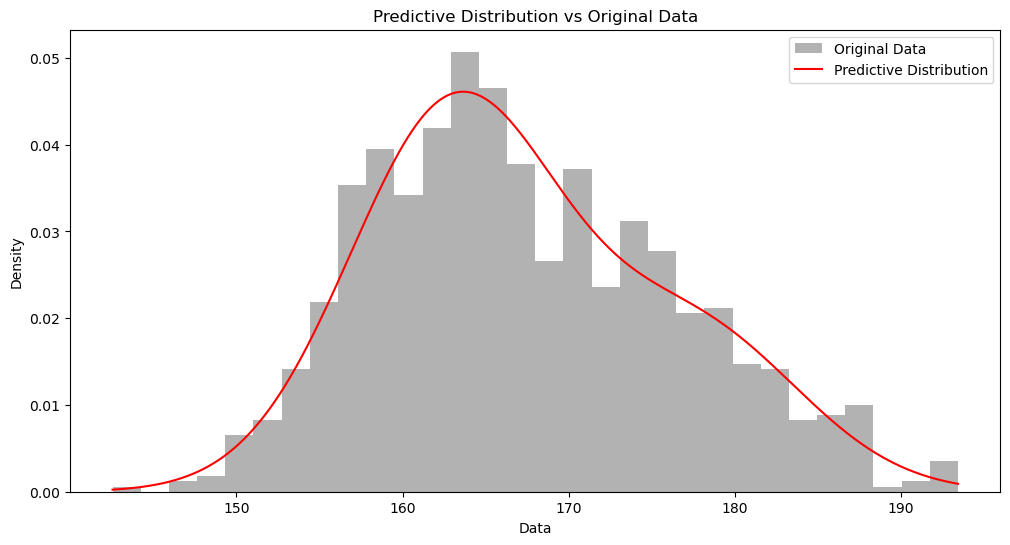

In [19]:
plot_predictive_distribution(data, assignments, cluster_params)

## 用 Dirichlet Process 当作先验

我们上面用的是均匀分布做先验，这需要我们提前假设一个可能的簇数。但如果我们不想假设怎么办？

可以选择用 Dirichlet Process 做先验分布。这样，我们不用提前设定有多少个簇，而是通过设定 `alpha` 来决定新开一个簇的概率。

根据 [Dirichlet Process](/cn/2024/12/11/dp/) 或者[中餐馆过程](/cn/2024/11/27/crp/)，一个新的数据点属于某个大簇的概率要大于无限个很小的簇，这符合贝叶斯统计后验概率的更新逻辑。

完整代码如下：

In [20]:
# Initialization
dp_alpha = 2
iterations = 1000
nsampling = 100
ndata = len(data)

# Default Parameters
default_params = {
    'mu': np.mean(data),
    'kappa': 1,  # Lower = more spread in means
    'alpha': 1,    # Lower = more variance in cluster widths
    'beta': np.var(data)   # Higher = wider clusters
}

# Record parameters
cluster_params = {0:default_params.copy()}
p1_history = []
params_history = []
assignments = np.zeros(ndata, dtype=np.int64)
assignments_history = []

start_time = time.time()

for it in range(iterations):
    # Initialize a list to store p1 for all data points in this iteration
    p1_iteration = np.empty(ndata, dtype=object)

    # Sample mus and sigmas for each cluster
    all_mus = {}
    all_sigmas = {}
    for k, k_params in cluster_params.items():
        sigma2_samples = invgamma.rvs(k_params['alpha'], scale = k_params['beta'], size = nsampling)
        sigma_samples = np.sqrt(sigma2_samples)
        mu_samples = norm.rvs(k_params["mu"], sigma_samples/np.sqrt(k_params['kappa']))
        all_mus[k] = mu_samples
        all_sigmas[k] = sigma_samples
    
    for idx, d in enumerate(data):
        # Step 1: Assign each data point to a cluster
        # For the first data point, assign it to the first table 
        if idx == 0:
            assignments[idx] = 0
            p1_iteration[idx] = [calculate_average_likelihood(d, all_mus[0], all_sigmas[0])]
            continue

        # All existing assignments up until the current data point
        curr_assignments = assignments[:idx] # excluding assignments[idx：]
        choices = np.arange(0, max(curr_assignments) + 2)
        # How many customers are there on kth table
        # bincount will consider all nums [0, max(X)]. If a num does not exist, it will be 0
        # So bincount will return an array of length of max(X)
        n_k = np.bincount(curr_assignments)
        # Total "customers" before this data point
        curr_total = idx + dp_alpha
        probs = np.append(n_k/curr_total, dp_alpha/curr_total)
        # This is to calculate p1 below
        # key is cluster id, value is the associated probability of assigning this datum to that cluster
        curr_prior = dict(zip(choices, probs))

        # Step 2: Calculate P(z_i = k | x_i) for all clusters
        p1 = np.zeros(len(curr_prior), dtype=float)
        for k_idx, k in enumerate(curr_prior.keys()):
            # if cluster is new, initiate params for this cluster
            if k not in cluster_params:
                cluster_params[k] = default_params.copy()
                sigma2_samples = invgamma.rvs(default_params['alpha'], scale = default_params['beta'], size = nsampling)
                sigma_samples = np.sqrt(sigma2_samples)
                mu_samples = norm.rvs(default_params["mu"], sigma_samples/np.sqrt(default_params['kappa']))
                all_mus[k] = mu_samples
                all_sigmas[k] = sigma_samples
            # Prior times the likelihood
            p1[k_idx] = curr_prior[k] * calculate_average_likelihood(d, all_mus[k], all_sigmas[k])
        p1_iteration[idx] = p1

        # Sampling based on posterior
        p1_normalized = p1 / np.sum(p1)  # Normalization
        assignments[idx] = np.random.choice(choices, p=p1_normalized)
  
    # Remove empty clusters from cluster_params
    empty_clusters = [x for x in cluster_params.keys() if x not in np.unique(assignments)]
    for k in empty_clusters:
        del cluster_params[k]
        del all_mus[k]
        del all_sigmas[k]

    # Step 3: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k in cluster_params.keys():
        cluster_data = data[assignments == k]
        n = len(cluster_data)

        if n == 0:
            continue
        x_bar = np.mean(cluster_data)

        kappa_n = default_params['kappa'] + n
        mu_n = (default_params['kappa'] * default_params['mu'] + n * x_bar) / kappa_n
        alpha_n = default_params['alpha'] + 0.5 * n
        beta_n = default_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
            default_params['kappa'] * n * (x_bar - default_params['mu'])**2) / (2 * kappa_n)
            
        cluster_params[k] = {
            'mu': mu_n,
            "kappa": kappa_n,
            "alpha": alpha_n,
            "beta": beta_n
        }
        
    # keep data from this iteration 
    if (it + 1) % 100 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
    p1_history.append(p1_iteration.copy())
    params_history.append({k: v.copy() for k, v in cluster_params.items()})
    assignments_history.append(assignments.copy())

Iteration 100 completed! Time elapsed: 5.17s
Iteration 200 completed! Time elapsed: 10.37s
Iteration 300 completed! Time elapsed: 15.44s
Iteration 400 completed! Time elapsed: 20.53s
Iteration 500 completed! Time elapsed: 25.67s
Iteration 600 completed! Time elapsed: 30.59s
Iteration 700 completed! Time elapsed: 35.74s
Iteration 800 completed! Time elapsed: 40.87s
Iteration 900 completed! Time elapsed: 45.94s
Iteration 1000 completed! Time elapsed: 50.97s


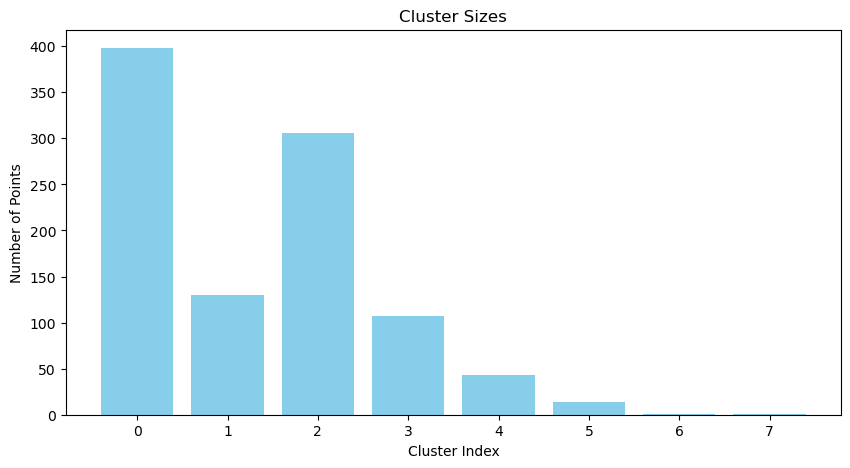

In [23]:
plot_cluster_sizes(assignments)

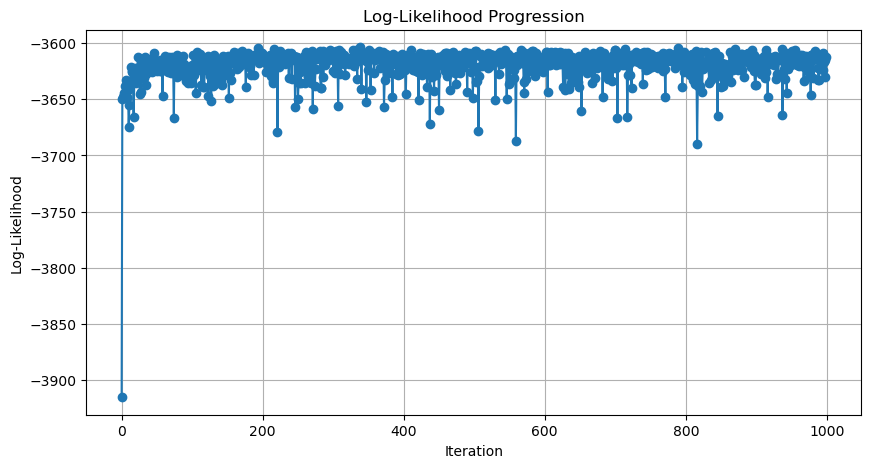

In [24]:
plot_log_likelihood_progression(p1_history)

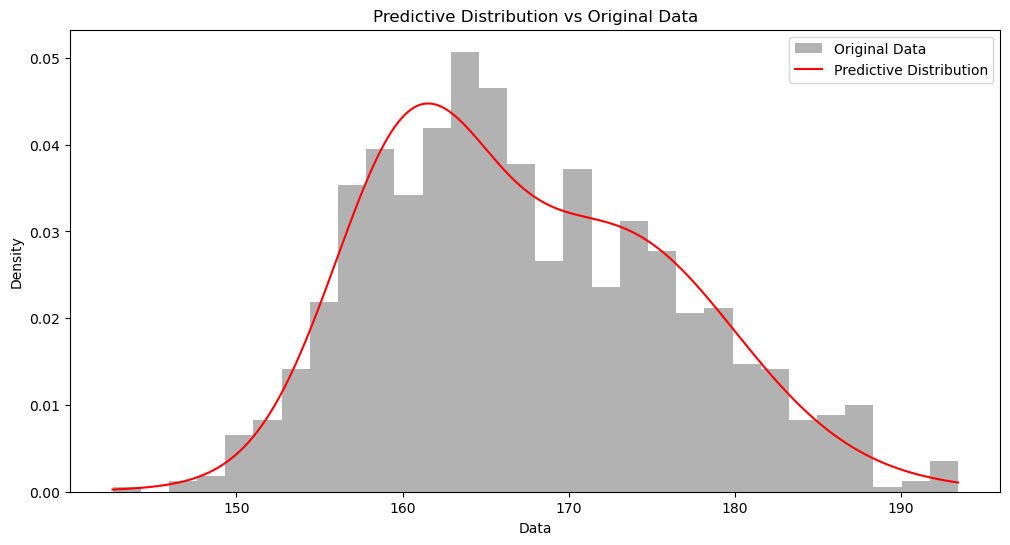

In [25]:
plot_predictive_distribution(data, assignments, cluster_params)